# Import the neccessary libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preproccess data methods

In [2]:
# Function to preprocess image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype("float32") / 255.0
    return img_normalized

def preprocess_data():
    # Load and preprocess train and test data
    train_dir = 'train'
    test_dir = 'test'

    train_filepaths = []
    train_labels = []
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        for filename in os.listdir(label_dir):
            filepath = os.path.join(label_dir, filename)
            train_filepaths.append(filepath)
            train_labels.append(label)

    test_filepaths = []
    test_labels = []
    for label in os.listdir(test_dir):
        label_dir = os.path.join(test_dir, label)
        for filename in os.listdir(label_dir):
            filepath = os.path.join(label_dir, filename)
            test_filepaths.append(filepath)
            test_labels.append(label)

    x_train = np.array([preprocess_image(filepath) for filepath in train_filepaths])
    y_train = np.array(train_labels)
    x_test = np.array([preprocess_image(filepath) for filepath in test_filepaths])
    y_test = np.array(test_labels)

    # Convert labels to numerical values
    label_to_index = {label: i for i, label in enumerate(np.unique(y_train))}
    y_train = np.array([label_to_index[label] for label in y_train])
    y_test = np.array([label_to_index[label] for label in y_test])

    return x_train, y_train, x_test, y_test, train_filepaths, train_labels, test_filepaths, test_labels


# Create datasets and shuffle the train dataset

In [3]:
x_train, y_train, x_test, y_test, train_filepaths, train_labels, test_filepaths, test_labels = preprocess_data()

# Shuffle indices
shuffled_indices = np.random.permutation(len(x_train))

# Shuffle x_train and y_train accordingly
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [4]:
trainData =pd.DataFrame({'filepath':train_filepaths,'label':train_labels}) 
trainData.head()

,filepath,label
0,train\Covid\01.jpeg,Covid
1,train\Covid\010.png,Covid
2,train\Covid\012.jpeg,Covid
3,train\Covid\015.jpg,Covid
4,train\Covid\019.png,Covid


In [5]:
testData =pd.DataFrame({'filepath':test_filepaths,'label':test_labels}) 
testData.head()

,filepath,label
0,test\Covid\0100.jpeg,Covid
1,test\Covid\0102.jpeg,Covid
2,test\Covid\0105.png,Covid
3,test\Covid\0106.jpeg,Covid
4,test\Covid\0108.jpeg,Covid


# Show some images from the dataset:

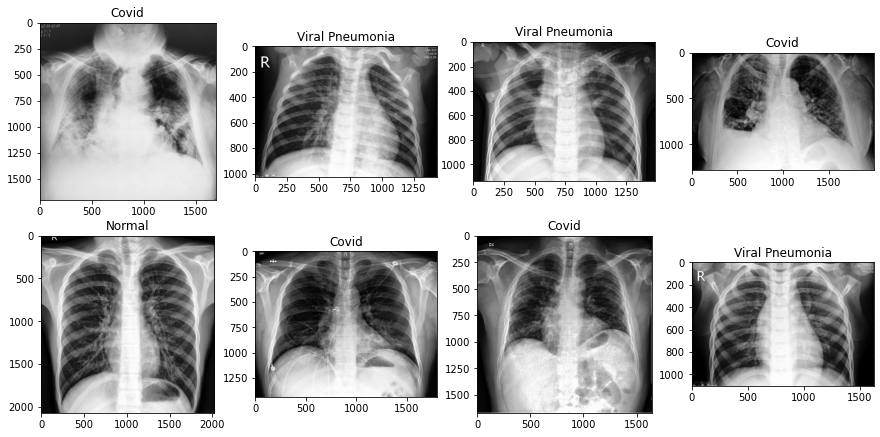

In [6]:
# Shuffle indices
shuffled_indices = list(range(len(trainData)))
random.shuffle(shuffled_indices)

# Shuffle data based on shuffled indices
shuffled_train_data = trainData.iloc[shuffled_indices].reset_index(drop=True)

# Show some samples from the shuffled train dataset
fig = plt.figure(figsize=(15, 15))
for i in range(8):
    fig.add_subplot(4, 4, i + 1).set_title(shuffled_train_data['label'][i])
    img = cv2.imread(shuffled_train_data['filepath'][i])
    plt.imshow(img)

plt.show()

# Check dataset distribution

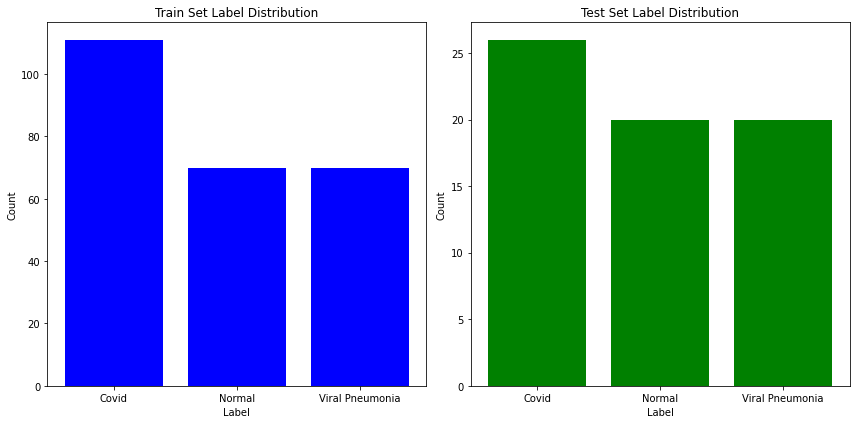

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each label in the train set
train_label_counts = trainData['label'].value_counts()

# Count occurrences of each label in the test set
test_label_counts = testData['label'].value_counts()

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for train set
axs[0].bar(train_label_counts.index, train_label_counts.values, color='blue')
axs[0].set_title('Train Set Label Distribution')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

# Plot histogram for test set
axs[1].bar(test_label_counts.index, test_label_counts.values, color='green')
axs[1].set_title('Test Set Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


### the data has more indices of covid, but got enough samples from each label.

# Split the train set to train and validation set and print the amount of the samples in each set:

In [8]:
# first create validation set
#split the train
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert categorical labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, 3)
y_val_onehot = tf.keras.utils.to_categorical(y_val, 3)

# Convert it also for the test set
y_test_onehot = tf.keras.utils.to_categorical(y_test, 3)


# Print the length of train, validation and test sets
print("Num of samples in train set: ", len(y_train_onehot))
print("Num of samples in validation set: ", len(y_val_onehot))
print("Num of samples in test set: ", len(y_test_onehot))

Num of samples in train set:  200
Num of samples in validation set:  51
Num of samples in test set:  66


# Simple softmax model

In [9]:
# Define a simple neural network model with softmax activation
class SoftmaxModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SoftmaxModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(256, 256, 3))  # Flatten input images
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the softmax model
num_classes = 3  # Number of classes
model = SoftmaxModel(num_classes)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(x_val, y_val_onehot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)

Epoch 1/50
7/7 [==============================] - 1s 35ms/step - loss: 23.7864 - accuracy: 0.4450 - val_loss: 2.7173 - val_accuracy: 0.8235
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 6.5498 - accuracy: 0.6850 - val_loss: 2.1498 - val_accuracy: 0.8627
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 5.8151 - accuracy: 0.7900 - val_loss: 1.7222 - val_accuracy: 0.9216
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 6.1036 - accuracy: 0.7600 - val_loss: 2.8729 - val_accuracy: 0.8824
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 6.5122 - accuracy: 0.8000 - val_loss: 2.2584 - val_accuracy: 0.9608
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 3.3399 - accuracy: 0.8700 - val_loss: 3.7424 - val_accuracy: 0.8824
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 4.1818 - accuracy: 0.8900 - val_loss: 3.4724 - val_accuracy: 0.8627
Epoch 8/50
7/7 [==========

### got accuracy of 84%.

# simple NN model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Define a Sequential model
model = Sequential([
    Flatten(input_shape=(256, 256, 3)),  # Flatten input images
    Dense(256, activation='relu'),  # First dense layer with ReLU activation
    Dense(128, activation='relu'),  # Second dense layer with ReLU activation
    Dense(64, activation='relu'),  # third dense layer with ReLU activation
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Define learning rate
# learning_rate = 0.001

# Create an optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(x_val, y_val_onehot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)


Epoch 1/50
7/7 [==============================] - 3s 342ms/step - loss: 48.1384 - accuracy: 0.4250 - val_loss: 12.8906 - val_accuracy: 0.5882
Epoch 2/50
7/7 [==============================] - 2s 334ms/step - loss: 9.2141 - accuracy: 0.6550 - val_loss: 1.5538 - val_accuracy: 0.8235
Epoch 3/50
7/7 [==============================] - 2s 333ms/step - loss: 1.7974 - accuracy: 0.8250 - val_loss: 3.5315 - val_accuracy: 0.7451
Epoch 4/50
7/7 [==============================] - 3s 366ms/step - loss: 2.7524 - accuracy: 0.7650 - val_loss: 0.6767 - val_accuracy: 0.9608
Epoch 5/50
7/7 [==============================] - 3s 392ms/step - loss: 3.0288 - accuracy: 0.7950 - val_loss: 5.7893 - val_accuracy: 0.7255
Epoch 6/50
7/7 [==============================] - 3s 370ms/step - loss: 4.1143 - accuracy: 0.7600 - val_loss: 4.3242 - val_accuracy: 0.7843
Epoch 7/50
7/7 [==============================] - 3s 367ms/step - loss: 4.5474 - accuracy: 0.8000 - val_loss: 4.3335 - val_accuracy: 0.7451
Epoch 8/50
7/7 [==

### got accuracy of 86%.


# CNN model

In [40]:
CNNModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

CNNModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = CNNModel.fit(x_train, y_train_onehot, epochs=10, batch_size=16, validation_data=(x_val, y_val_onehot))

test_loss, test_acc = CNNModel.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)


Epoch 1/10
13/13 [==============================] - 9s 671ms/step - loss: 4.7771 - accuracy: 0.5250 - val_loss: 0.8782 - val_accuracy: 0.5294
Epoch 2/10
13/13 [==============================] - 11s 880ms/step - loss: 0.5800 - accuracy: 0.8050 - val_loss: 0.4957 - val_accuracy: 0.8235
Epoch 3/10
13/13 [==============================] - 10s 795ms/step - loss: 0.2729 - accuracy: 0.9150 - val_loss: 0.3147 - val_accuracy: 0.9020
Epoch 4/10
13/13 [==============================] - 10s 772ms/step - loss: 0.2245 - accuracy: 0.9150 - val_loss: 0.3490 - val_accuracy: 0.9020
Epoch 5/10
13/13 [==============================] - 10s 755ms/step - loss: 0.1049 - accuracy: 0.9650 - val_loss: 0.1550 - val_accuracy: 0.9412
Epoch 6/10
13/13 [==============================] - 10s 760ms/step - loss: 0.0592 - accuracy: 0.9850 - val_loss: 0.1958 - val_accuracy: 0.9412
Epoch 7/10
13/13 [==============================] - 10s 761ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.9020


## Got accuracy of 96%!

### Lets plot the aacuracy and loss of train set and validation set through the training proccess

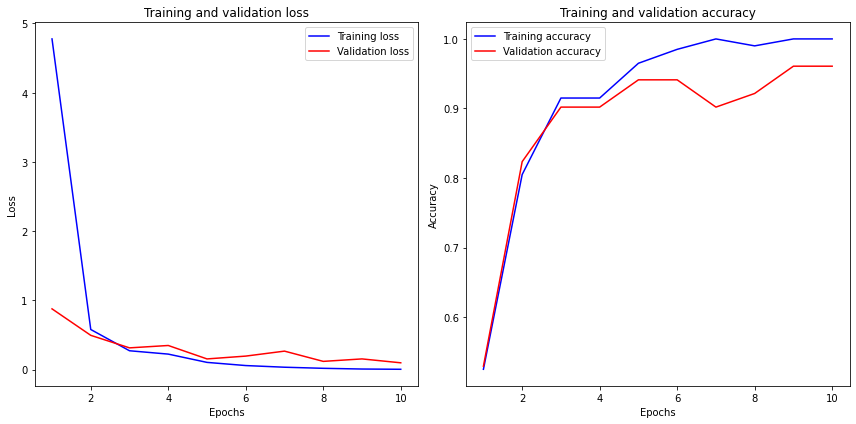

In [41]:
# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting loss and accuracy side by side
plt.figure(figsize=(12, 6))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()  # Adjust spacing between subplots for better readability
plt.show()

### It looks good! the train and validation loss and accuracy goes together.

### Show the confusion matrix and the precision, recall and F-1 score:

3/3 [==============================] - 0s 101ms/step


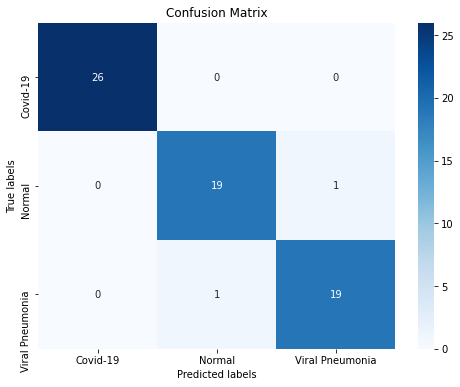

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming CNNModel is already trained and x_test contains the test data

# Define class labels
labels = ['Covid-19', 'Normal', 'Viral Pneumonia']

# Predict labels for test data
y_pred = np.argmax(CNNModel.predict(x_test), axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [43]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Compute precision, recall, and accuracy
precision = precision_score(y_test_labels, y_pred, average=None)
recall = recall_score(y_test_labels, y_pred, average=None)
accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average=None)

# Print precision, recall, and accuracy for each class
for i, label in enumerate(labels):
    print(f"{label}:")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1 Score: {f1[i]}")
    print()

# Print overall accuracy
print("Overall Accuracy:", accuracy)


Covid-19:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Normal:
  Precision: 0.95
  Recall: 0.95
  F1 Score: 0.9500000000000001

Viral Pneumonia:
  Precision: 0.95
  Recall: 0.95
  F1 Score: 0.9500000000000001

Overall Accuracy: 0.9696969696969697


### 96% accuracy (almost 97%)!

# Try with data augmentation

In [46]:
train_dir = 'train'
test_dir = 'test'

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Flow images in batches from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # adjust for your problem
    subset='training'           # specify subset as 'training' for training data
)

# Flow validation images in batches from directory
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',   # adjust for your problem
    subset='validation'         # specify subset as 'validation' for validation data
)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)
print("Test Accuracy:", test_acc)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/50
6/6 [==============================] - 13s 2s/step - loss: 1.2320 - accuracy: 0.4438 - val_loss: 1.0914 - val_accuracy: 0.3125
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 1.0072 - accuracy: 0.5260 - val_loss: 0.8692 - val_accuracy: 0.5938
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.7913 - accuracy: 0.6391 - val_loss: 0.6171 - val_accuracy: 0.7500
Epoch 4/50
6/6 [==============================] - 12s 2s/step - loss: 0.5509 - accuracy: 0.7929 - val_loss: 0.6098 - val_accuracy: 0.7188
Epoch 5/50
6/6 [==============================] - 13s 2s/step - loss: 0.6482 - accuracy: 0.7456 - val_loss: 0.4931 - val_accuracy: 0.7500
Epoch 6/50
6/6 [==============================] - 13s 2s/step - loss: 0.4302 - accuracy: 0.8107 - val_loss: 0.6790 - val_accuracy: 0.6875
Epoch 7/50
6/6 [==============================] - 13s 2s/step - loss: 0.4411 - accuracy: 0.

## In conclusion we can see that the CNN (without the data augmentation) was the best model with 96% of accuracy.